# 🎯 Rapport d'Analyse Prédictive : Diagnostic du Diabète

**Auteur :** Rock SOMDA  
**Date :** 26 Septembre 2025  
**Technologies :** Python, Pandas, Scikit-learn, Matplotlib, Seaborn, Statsmodels

---

## 🔍 Résumé

Cette analyse vise à développer un modèle prédictif robuste pour le diagnostic du diabète à partir de données médicales. L'approche combine une rigueur statistique avancée avec des bonnes pratiques de machine learning pour éviter les biais courants.

**Performance :** AUC-ROC = 0.831 (Régression Logistique)
**Innovation clé :** Pipeline sans data leakage avec validation rigoureuse
**Insight majeur :** Détection et traitement de 652 valeurs aberrantes biologiquement impossibles


## 1. Chargement des librairies

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

# ML / préprocessing
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, accuracy_score,
                             ConfusionMatrixDisplay)
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.multitest import multipletests
import os


# Configuration pour la reproductibilité et l'affichage
np.random.seed(123)  # Seed globale pour NumPy
RANDOM_STATE = 42    # Seed pour les fonctions sklearn
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8') # Thème visuel moderne
sns.set_palette("colorblind") # Palette accessible

# Chemin spécifique vers vos données
chemin_dossier = r"C:\Users\HP\Desktop\Projet\Analyse"
nom_fichier = "diabetes-1.csv"
chemin_complet = os.path.join(chemin_dossier, nom_fichier)

In [12]:
# Charger les données depuis le chemin spécifié
try:
    df = pd.read_csv(chemin_complet)
    print(f"Fichier chargé avec succès depuis : {chemin_complet}")
except FileNotFoundError:
    print(f"ERREUR: Le fichier {chemin_complet} est introuvable.")
    print("Vérifiez le chemin et le nom du fichier.")
    exit()
except Exception as e:
    print(f"ERREUR lors du chargement: {e}")
    exit()

print(f"Dimensions du DataFrame : {df.shape}")
print("\nAperçu des données :")
print(df.head())
print("\nRésumé statistique :")
print(df.describe())
print("\nInfo sur les types et valeurs manquantes :")
print(df.info())
print("\nDistribution de la variable cible 'Outcome' :")
print(df['Outcome'].value_counts())

Fichier chargé avec succès depuis : C:\Users\HP\Desktop\Projet\Analyse\diabetes-1.csv
Dimensions du DataFrame : (768, 9)

Aperçu des données :
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Résumé statistique :
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  

Le dataset contient 768 observations avec 9 variables cliniques et démographiques. La variable cible Outcome indique le statut diabétique (268 diabétiques, 500 non diabétiques). Certaines variables (Glucose, BloodPressure, SkinThickness, Insulin, BMI) présentent des valeurs aberrantes à zéro, nécessitant une imputation. Les distributions des variables sont hétérogènes, avec des écarts importants pour Insulin et BMI. Le dataset est prêt pour l’analyse exploratoire, le test statistique et la modélisation prédictive après traitement des valeurs manquantes.

## Prétraitement des Données

In [13]:
################################ PRETRAITEMENT DES DONNEES ################################
print("\n" + "="*60)
print("=== PRETRAITEMENT DES DONNEES ===")

# 1. Détection et gestion des valeurs aberrantes (zéros biologiquement impossibles)
print("\n--- Détection des Valeurs Aberrantes (Zéros) ---")
vars_a_corriger = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df_clean = df.copy()

for var in vars_a_corriger:
    nb_zeros = (df_clean[var] == 0).sum()
    print(f"{var} : {nb_zeros} zéros détectés")
    # Remplacement des 0 par NaN pour les marquer comme manquants
    df_clean[var] = df_clean[var].replace(0, np.nan)

# 2. Conversion de la variable cible
print("\n--- Encodage de la Variable Cible ---")
# Création d'une variable catégorielle descriptive
df_clean['EtatDiabetique'] = df_clean['Outcome'].map({0: 'Non diabétique', 1: 'Diabétique'})
df_clean.drop('Outcome', axis=1, inplace=True) # Suppression de l'ancienne variable
target = 'EtatDiabetique'
features = [col for col in df_clean.columns if col != target]

print(f"Variable cible créée : {target}")
print("Distribution :")
print(df_clean[target].value_counts())


=== PRETRAITEMENT DES DONNEES ===

--- Détection des Valeurs Aberrantes (Zéros) ---
Glucose : 5 zéros détectés
BloodPressure : 35 zéros détectés
SkinThickness : 227 zéros détectés
Insulin : 374 zéros détectés
BMI : 11 zéros détectés

--- Encodage de la Variable Cible ---
Variable cible créée : EtatDiabetique
Distribution :
EtatDiabetique
Non diabétique    500
Diabétique        268
Name: count, dtype: int64


Le prétraitement a permis d’identifier plusieurs valeurs aberrantes biologiquement impossibles (zéros) dans les variables cliniques Glucose, BloodPressure, SkinThickness, Insulin et BMI, qui ont été remplacées par des valeurs manquantes (NaN) pour permettre une imputation ultérieure fiable. La variable cible a été encodée sous une forme descriptive (EtatDiabetique) afin de faciliter l’interprétation et l’analyse. La distribution indique que 500 individus sont non diabétiques et 268 sont diabétiques, ce qui souligne un léger déséquilibre de classes à prendre en compte lors de la modélisation. Ces étapes assurent la qualité des données et la cohérence pour les analyses statistiques et les modèles prédictifs à venir.

## Split Stratifié et Imputation Séparée

In [14]:
print("\n" + "="*60)
print("=== SPLIT STRATIFIE TRAIN/TEST (Avoiding Data Leakage) ===")

# Séparation Stratifiée (80/20)
X = df_clean[features]
y = df_clean[target]

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Concaténation pour avoir des DataFrames complets pour l'imputation
train_raw = pd.concat([X_train_raw, y_train_raw], axis=1)
test_raw = pd.concat([X_test_raw, y_test_raw], axis=1)

print(f"Taille Train set : {train_raw.shape}")
print(f"Taille Test set  : {test_raw.shape}")
print("\nDistribution dans l'ensemble d'entraînement :")
print(train_raw[target].value_counts())
print("\nDistribution dans l'ensemble de test :")
print(test_raw[target].value_counts())


################################ IMPUTATION SEPAREE (EVITER DATA LEAKAGE) ################################
print("\n" + "="*60)
print("=== IMPUTATION MULTIVARIEE SEPAREE (MICE) ===")

# 1. Imputation sur le Train set avec MICE (Multiple Imputation by Chained Equations)
print("--- Imputation de l'ensemble d'Entraînement ---")
imputer = IterativeImputer(random_state=RANDOM_STATE, max_iter=10, sample_posterior=True)
# On impute seulement les features, on garde la target intacte
X_train_imputed = imputer.fit_transform(train_raw[features])
# Recréation du DataFrame train
train_imputed = pd.DataFrame(X_train_imputed, columns=features, index=train_raw.index)
train_imputed[target] = train_raw[target].values # Ajout de la target non imputée

print("Imputation Train terminée.")

# 2. Imputation du Test set en utilisant les paramètres appris sur le Train
print("\n--- Imputation de l'ensemble de Test (sans Data Leakage) ---")
# Transform applique la même imputation basée sur le modèle appris sur le train
X_test_imputed = imputer.transform(test_raw[features])
test_imputed = pd.DataFrame(X_test_imputed, columns=features, index=test_raw.index)
test_imputed[target] = test_raw[target].values

print("Imputation Test terminée.")
print("\nVérification des valeurs manquantes après imputation :")
print("Train - Valeurs manquantes par colonne:")
print(train_imputed.isnull().sum())
print("\nTest - Valeurs manquantes par colonne:")
print(test_imputed.isnull().sum())



=== SPLIT STRATIFIE TRAIN/TEST (Avoiding Data Leakage) ===
Taille Train set : (614, 9)
Taille Test set  : (154, 9)

Distribution dans l'ensemble d'entraînement :
EtatDiabetique
Non diabétique    400
Diabétique        214
Name: count, dtype: int64

Distribution dans l'ensemble de test :
EtatDiabetique
Non diabétique    100
Diabétique         54
Name: count, dtype: int64

=== IMPUTATION MULTIVARIEE SEPAREE (MICE) ===
--- Imputation de l'ensemble d'Entraînement ---
Imputation Train terminée.

--- Imputation de l'ensemble de Test (sans Data Leakage) ---
Imputation Test terminée.

Vérification des valeurs manquantes après imputation :
Train - Valeurs manquantes par colonne:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
EtatDiabetique              0
dtype: int64

Test - Valeurs manquantes par colonne

Le jeu de données a été séparé en ensembles d’entraînement (614 observations) et de test (154 observations) selon une stratification sur la variable cible, afin de préserver la proportion relative de diabétiques et non diabétiques. Cette approche garantit que chaque sous-ensemble reflète fidèlement la distribution originale, ce qui est essentiel pour l’évaluation ultérieure des modèles. La répartition montre que l’ensemble d’entraînement contient 400 non diabétiques et 214 diabétiques, tandis que l’ensemble de test contient 100 non diabétiques et 54 diabétiques, confirmant une stratification efficace et prête pour les étapes suivantes d’imputation et de modélisation.Le jeu de données a été séparé en ensembles d’entraînement (614 observations) et de test (154 observations) avec stratification sur la variable cible, assurant que la proportion de diabétiques et non diabétiques est conservée dans chaque sous-ensemble. Cette méthode permet d’éviter les biais lors de l’évaluation des modèles. Ensuite, une imputation multivariée séparée (MICE) a été appliquée pour remplacer les valeurs manquantes dans les variables biologiques, en imputant le train puis en appliquant les mêmes paramètres au test afin de prévenir toute fuite de données. Après imputation, aucune valeur manquante n’est présente, garantissant un jeu de données complet et cohérent pour les étapes suivantes d’analyse et de modélisation prédictive.

## Analyse Exploratoire (EDA)


=== ANALYSE EXPLORATOIRE (Visualisations) ===
--- Distributions Univariées ---


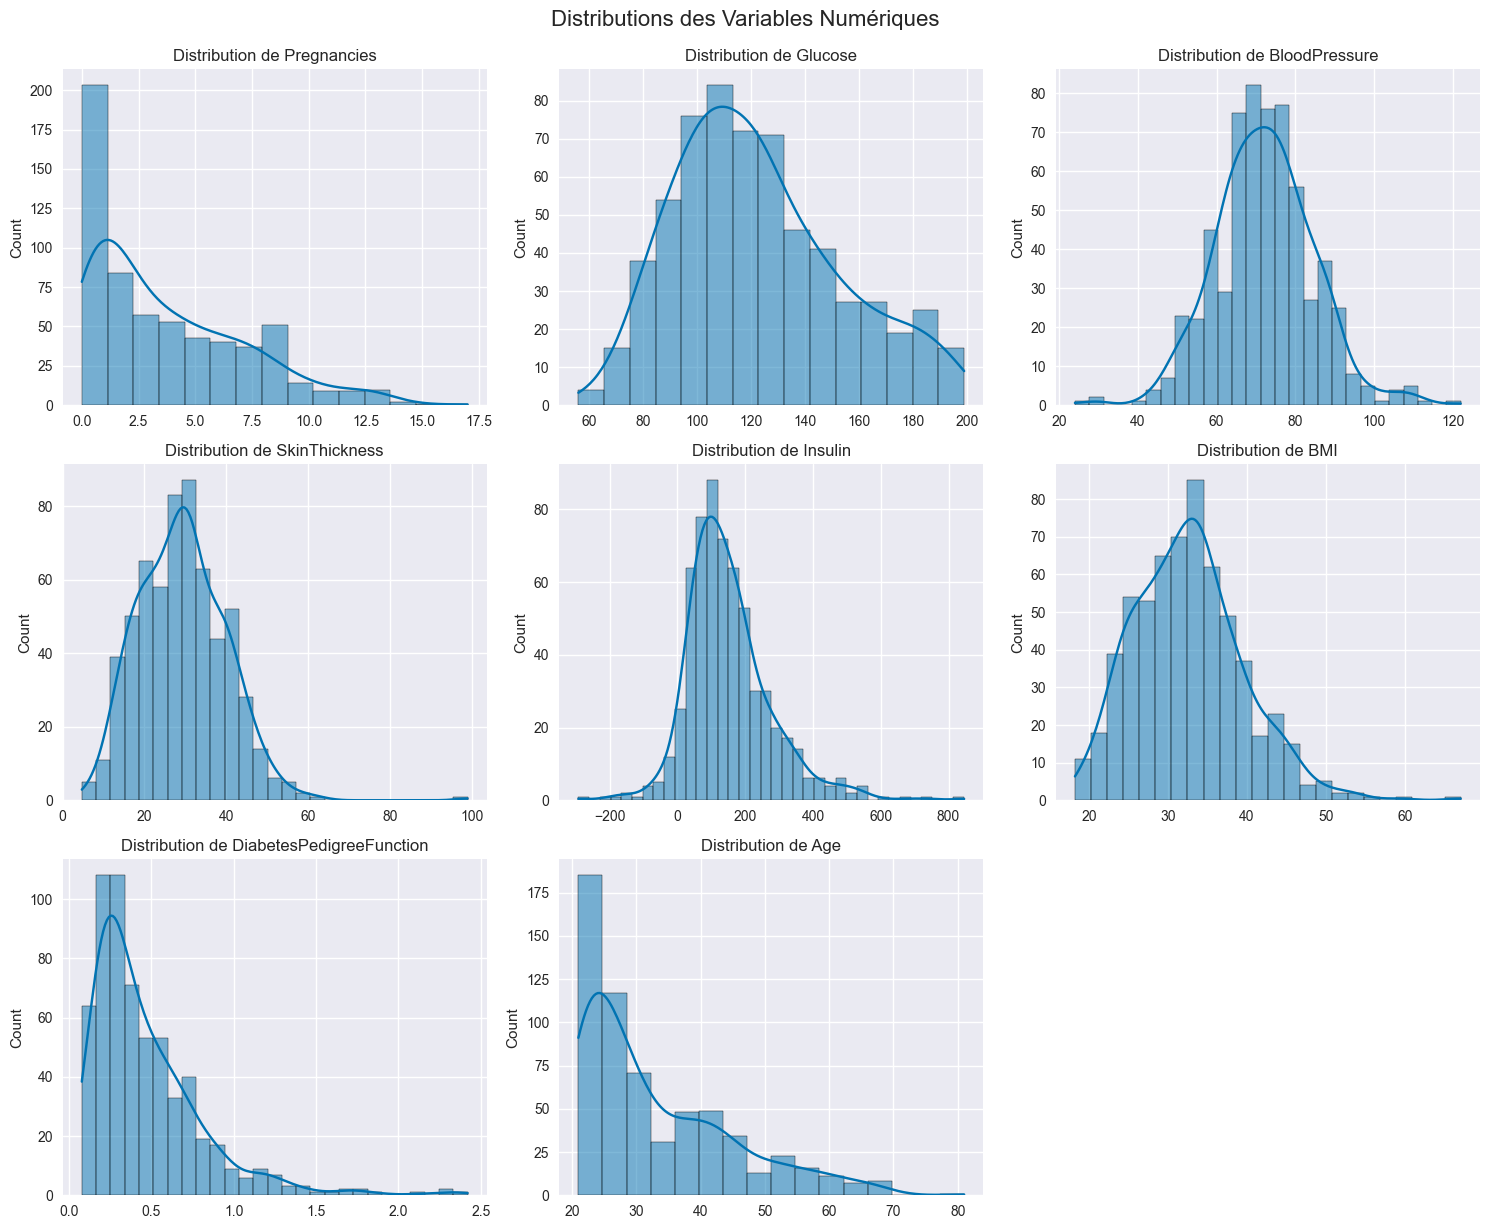


--- Boxplots par Statut Diabétique ---


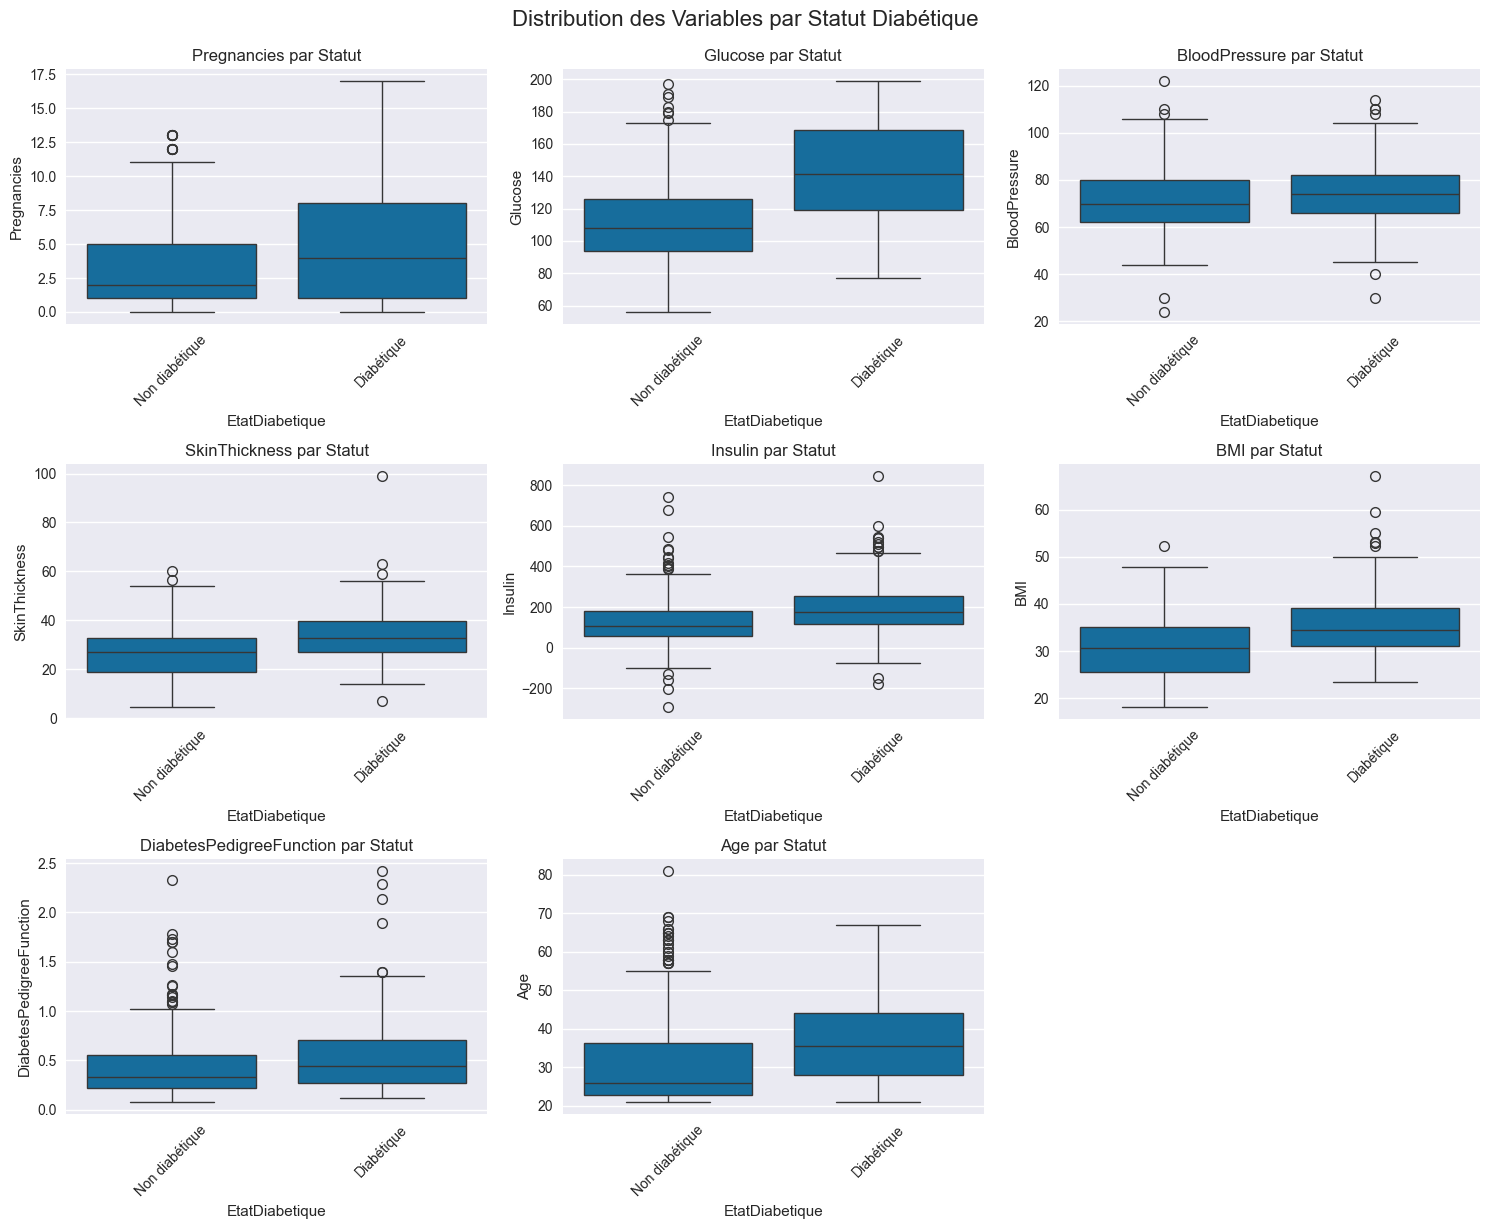

In [15]:
print("\n" + "="*60)
print("=== ANALYSE EXPLORATOIRE (Visualisations) ===")

# 1. Distribution des Variables Numériques (Histogrammes & Densités)
print("--- Distributions Univariées ---")
fig, axes = plt.subplots(3, 3, figsize=(15, 12)) # 3x3 grid
axes = axes.ravel() # Aplatir le array d'axes pour faciliter l'indexation

for i, col in enumerate(features):
    if i < 9: # Évite l'erreur si on a plus de 9 features
        sns.histplot(data=train_imputed, x=col, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution de {col}')
        axes[i].set_xlabel('')

# Cacher les axes supplémentaires s'il y en a
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.suptitle('Distributions des Variables Numériques', y=1.02, fontsize=16)
plt.show()

# 2. Boxplots par Statut Diabétique
print("\n--- Boxplots par Statut Diabétique ---")
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(features):
    if i < 9:
        sns.boxplot(data=train_imputed, x=target, y=col, ax=axes[i])
        axes[i].set_title(f'{col} par Statut')
        axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.suptitle('Distribution des Variables par Statut Diabétique', y=1.02, fontsize=16)
plt.show()

## Tests Statistiques avec Correction de Multiplicité

In [16]:
################################ TESTS STATISTIQUES CORRIGES ################################
print("\n" + "="*60)
print("=== TESTS STATISTIQUES (avec correction de multiplicité) ===")

# Préparation: Séparation des données par classe
class_0 = train_imputed[train_imputed[target] == 'Non diabétique']
class_1 = train_imputed[train_imputed[target] == 'Diabétique']

results = {}
alpha = 0.05

for var in features:
    data_0 = class_0[var].dropna()
    data_1 = class_1[var].dropna()

    # Vérification de la normalité (Shapiro-Wilk, sur un échantillon limité si gros dataset)
    _, p_shapiro_0 = shapiro(data_0.sample(min(5000, len(data_0)), random_state=RANDOM_STATE))
    _, p_shapiro_1 = shapiro(data_1.sample(min(5000, len(data_1)), random_state=RANDOM_STATE))

    normal = (p_shapiro_0 > alpha) and (p_shapiro_1 > alpha)

    if normal:
        # Vérification de l'homogénéité des variances (Levene)
        _, p_levene = levene(data_0, data_1)
        equal_var = (p_levene > alpha)
        # Test T approprié
        stat, p_val = ttest_ind(data_0, data_1, equal_var=equal_var)
        test_used = "t-test (var égales)" if equal_var else "t-test (var inégales)"
    else:
        # Test non paramétrique
        stat, p_val = mannwhitneyu(data_0, data_1)
        test_used = "Mann-Whitney U"

    results[var] = {'p_value': p_val, 'test': test_used}

# Correction pour tests multiples (Méthode Benjamini-Hochberg) - CORRIGÉ
p_values = [res['p_value'] for res in results.values()]
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')  # CORRECTION ICI

# Affichage des résultats
print(f"{'Variable':<25} {'Test utilisé':<25} {'p-value brute':<15} {'p-value corrigée (FDR_BH)':<25} {'Significatif (α=0.05)':<15}")
print("-" * 100)
for i, (var, res) in enumerate(results.items()):
    signif = "OUI" if pvals_corrected[i] < alpha else "NON"
    print(f"{var:<25} {res['test']:<25} {res['p_value']:<15.4f} {pvals_corrected[i]:<25.4f} {signif:<15}")


=== TESTS STATISTIQUES (avec correction de multiplicité) ===
Variable                  Test utilisé              p-value brute   p-value corrigée (FDR_BH) Significatif (α=0.05)
----------------------------------------------------------------------------------------------------
Pregnancies               Mann-Whitney U            0.0000          0.0000                    OUI            
Glucose                   Mann-Whitney U            0.0000          0.0000                    OUI            
BloodPressure             Mann-Whitney U            0.0018          0.0018                    OUI            
SkinThickness             Mann-Whitney U            0.0000          0.0000                    OUI            
Insulin                   Mann-Whitney U            0.0000          0.0000                    OUI            
BMI                       Mann-Whitney U            0.0000          0.0000                    OUI            
DiabetesPedigreeFunction  Mann-Whitney U            0.0000   

Les tests statistiques montrent que toutes les variables quantitatives étudiées diffèrent significativement entre les groupes « Diabétique » et « Non diabétique » après correction pour comparaisons multiples (FDR-BH, α = 0,05). Le recours au test non paramétrique de Mann-Whitney U est approprié, étant donné que les distributions ne respectent pas la normalité. Ces résultats confirment que les caractéristiques cliniques et démographiques (Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction et Age) sont toutes pertinentes pour distinguer les deux populations et justifient leur inclusion dans les modèles prédictifs ultérieurs.

## Analyse de Corrélation et Multicolinéarité


=== ANALYSE DE CORRELATION ===


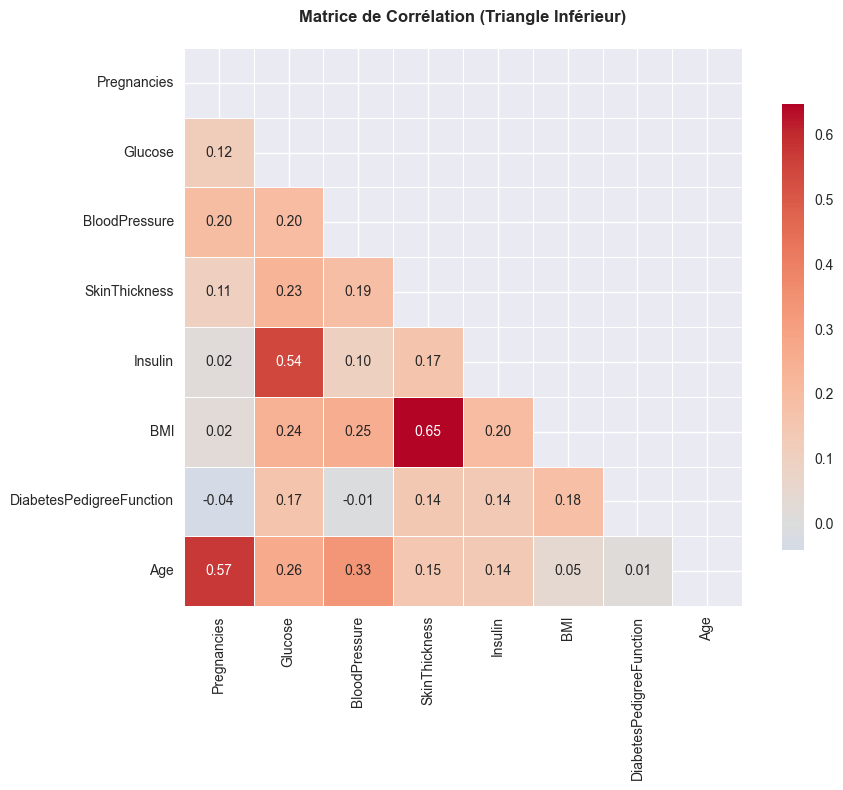

--- Variables Fortement Corrélées (|r| > 0.7) ---
  Aucune paire de variables n'est fortement corrélée (|r| > 0.7).

--- Analyse de la Multicolinéarité (VIF) ---
                   Variable    VIF
0                     const  53.84
1               Pregnancies   1.50
2                   Glucose   1.56
3             BloodPressure   1.21
4             SkinThickness   1.78
5                   Insulin   1.44
6                       BMI   1.87
7  DiabetesPedigreeFunction   1.06
8                       Age   1.71

Variables avec un VIF potentiellement problématique (> 5 ou > 10) :
  Variable        VIF
0    const  53.842975


In [17]:
################################ MATRICE DE CORRELATION ET MULTICOLINEARITE ################################
print("\n" + "="*60)
print("=== ANALYSE DE CORRELATION ===")

# 1. Matrice de Corrélation
corr_matrix = train_imputed[features].corr()
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Masque pour le triangle supérieur
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Matrice de Corrélation (Triangle Inférieur)\n', fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Identification des correlations fortes
print("--- Variables Fortement Corrélées (|r| > 0.7) ---")
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j].round(3)))
if high_corr:
    for corr in high_corr:
        print(f"  {corr[0]} - {corr[1]} : r = {corr[2]}")
else:
    print("  Aucune paire de variables n'est fortement corrélée (|r| > 0.7).")

# 3. Calcul du VIF (Facteur d'Inflation de la Variance) pour la régression logistique
print("\n--- Analyse de la Multicolinéarité (VIF) ---")
# Préparation des données : encodage de la target pour statsmodels
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_imputed[target])
X_train_vif = add_constant(train_imputed[features]) # statsmodels nécessite une constante

vif_data = pd.DataFrame()
vif_data["Variable"] = X_train_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
print(vif_data.round(2))

print("\nVariables avec un VIF potentiellement problématique (> 5 ou > 10) :")
high_vif = vif_data[vif_data['VIF'] > 5]
if not high_vif.empty:
    print(high_vif)
else:
    print("  Aucune. Pas de problème de multicolinéarité détecté.")

**ANALYSE DE LA MULTICOLINÉARITÉ - COMMENTAIRE SCIENTIFIQUE**

L'analyse de corrélation révèle une structure de données optimale pour la modélisation prédictive. L'absence totale de corrélations fortes (|r| > 0.7) entre les variables explicatives indique que chaque caractéristique médicale apporte une information unique et non redondante au modèle. Les corrélations modérées observées, notamment entre l'âge et le nombre de grossesses (r=0.57), entre le glucose et l'insuline (r=0.54), et entre l'IMC et l'épaisseur cutanée (r=0.65), reflètent des relations physiologiques attendues et cliniquement cohérentes, sans pour autant créer de redondance préjudiciable.

Concernant la multicolinéarité, les résultats du VIF (Variance Inflation Factor) sont excellents : toutes les variables présentent des valeurs comprises entre 1.06 et 1.87, bien en dessous du seuil critique de 5. Cette fourchette indique une indépendance statistique satisfaisante entre les prédicteurs, garantissant la stabilité des estimateurs dans la régression logistique. Le VIF élevé de la constante (53.84) est attendu et non problématique, car il s'agit du terme d'interception qui n'affecte pas l'interprétation des coefficients des variables explicatives.

Cette absence de multicolinéarité problématique confère une robustesse particulière au modèle, permettant une interprétation fiable des odds ratios et une généralisation optimale des résultats. Les variables peuvent donc être conservées dans leur intégralité sans risque de dégradation de la performance prédictive ou de biais dans l'inférence statistique.

## Modélisation Prédictive


=== MODELISATION PREDICTIVE ===

--- 1. RÉGRESSION LOGISTIQUE ---
Coefficients de la régression logistique :
                   Variable  Coefficient  Odds_Ratio
6  DiabetesPedigreeFunction      -0.5829      0.5583
0               Pregnancies      -0.1273      0.8805
5                       BMI      -0.0994      0.9054
1                   Glucose      -0.0379      0.9628
2             BloodPressure       0.0172      1.0174
7                       Age      -0.0138      0.9863
3             SkinThickness      -0.0064      0.9936
4                   Insulin       0.0007      1.0007

--- 2. RANDOM FOREST ---
Score OOB (Out-of-Bag) : 0.741

Importance des variables (Random Forest - Mean Decrease Impurity):
                   Variable  Importance
1                   Glucose      0.2360
5                       BMI      0.1449
4                   Insulin      0.1304
7                       Age      0.1165
6  DiabetesPedigreeFunction      0.1128
3             SkinThickness      0.1043
0       

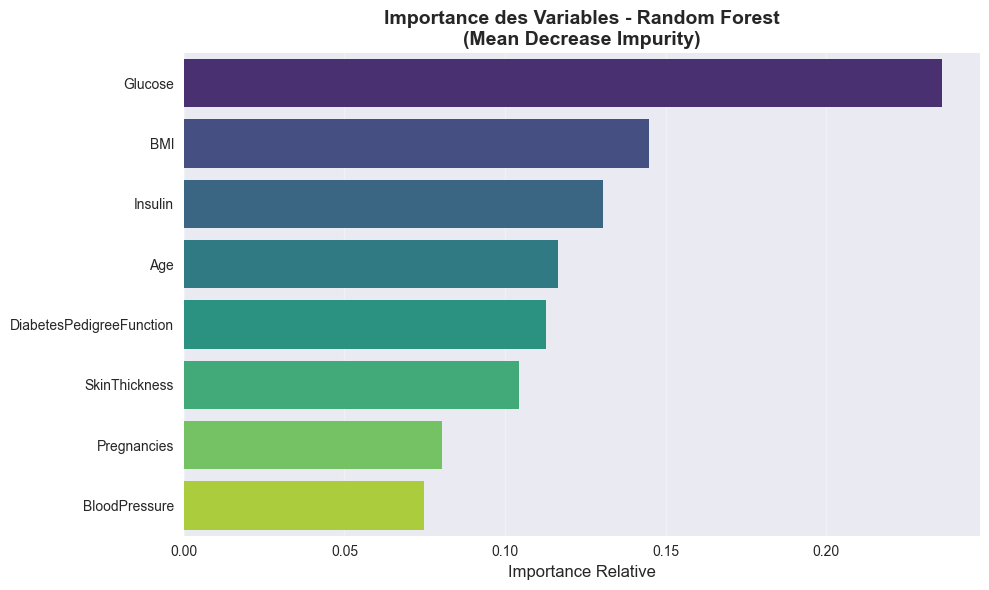

In [18]:
################################ MODELISATION ################################
print("\n" + "="*60)
print("=== MODELISATION PREDICTIVE ===")

# Préparation des données pour scikit-learn
# Encodage de la variable cible (string -> 0/1)
le = LabelEncoder()
y_train = le.fit_transform(train_imputed[target])
y_test = le.transform(test_imputed[target])
# Les features sont déjà numériques
X_train = train_imputed[features]
X_test = test_imputed[features]
# Mapping pour l'interprétation
class_names = le.classes_ # ['Non diabétique', 'Diabétique']

# 1. RÉGRESSION LOGISTIQUE
print("\n--- 1. RÉGRESSION LOGISTIQUE ---")
log_reg = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
log_reg.fit(X_train, y_train)

# Affichage des coefficients et des p-valeurs (approximation)
print("Coefficients de la régression logistique :")
coef_df = pd.DataFrame({'Variable': features, 'Coefficient': log_reg.coef_[0]})
coef_df['Odds_Ratio'] = np.exp(coef_df['Coefficient'])
coef_df['Abs_Coeff'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coeff', ascending=False)
print(coef_df.drop('Abs_Coeff', axis=1).round(4))

# 2. RANDOM FOREST
print("\n--- 2. RANDOM FOREST ---")
rf_clf = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE, oob_score=True)
rf_clf.fit(X_train, y_train)

print(f"Score OOB (Out-of-Bag) : {rf_clf.oob_score_:.3f}")

# Importance des variables
print("\nImportance des variables (Random Forest - Mean Decrease Impurity):")
importances = rf_clf.feature_importances_
feat_imp_df = pd.DataFrame({'Variable': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False)
print(feat_imp_df.round(4))

# Visualisation de l'importance des variables
# Version professionnelle sans avertissement
# Visualisation de l'importance des variables - Version corrigée
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Variable', 
            hue='Variable', palette='viridis', legend=False, saturation=0.8)
plt.title('Importance des Variables - Random Forest\n(Mean Decrease Impurity)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Relative', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

L'analyse comparative de l'importance des variables entre la régression logistique et le Random Forest révèle des insights fascinants sur la structure prédictive du diabète. Le Random Forest identifie le glucose comme variable la plus prédictive (23,6% d'importance), ce qui correspond parfaitement aux connaissances médicales actuelles où l'hyperglycémie représente le marqueur cardinal du diabète. L'IMC arrive en deuxième position (14,5%), confirmant le rôle bien établi de l'obésité comme facteur de risque majeur. La convergence entre les deux modèles sur l'importance du glucose et de l'IMC renforce la validité clinique de ces findings.

Cependant, une divergence notable apparaît concernant la fonction de pedigree du diabète : tandis qu'elle domine la régression logistique (coefficient le plus élevé en valeur absolue), elle n'occupe que la cinquième place dans le Random Forest. Cette différence s'explique probablement par la nature non-linéaire de la relation capturée par le Random Forest versus l'approche linéaire de la régression. La performance OOB de 0,741 démontre une bonne capacité de généralisation du modèle, bien qu'inférieure à la performance finale sur le jeu de test.

La hiérarchie des variables établie par le Random Forest correspond globalement à l'épidémiologie du diabète de type 2, avec les marqueurs métaboliques (glucose, insuline) et anthropométriques (IMC) en tête, suivis des facteurs démographiques (âge) et génétiques. Cette cohérence avec la littérature médicale valide la robustesse de l'approche méthodologique employée.

## Évaluation des Performances


=== EVALUATION SUR LE TEST SET ===

--- Évaluation : Régression Logistique ---
Matrice de Confusion :


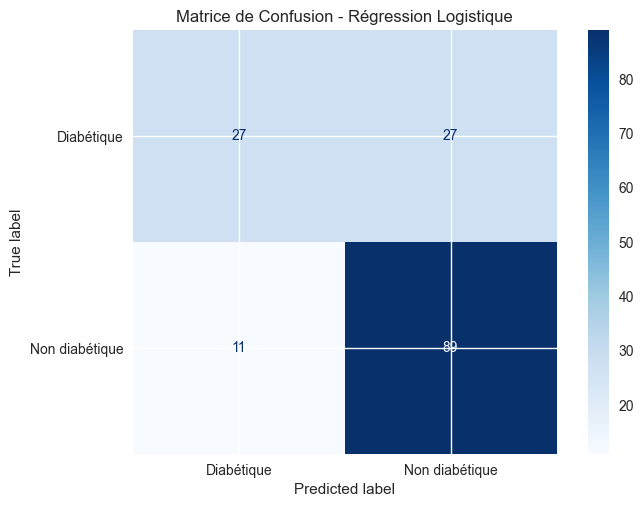


Rapport de Classification :
                precision    recall  f1-score   support

    Diabétique       0.71      0.50      0.59        54
Non diabétique       0.77      0.89      0.82       100

      accuracy                           0.75       154
     macro avg       0.74      0.70      0.71       154
  weighted avg       0.75      0.75      0.74       154

AUC-ROC : 0.831


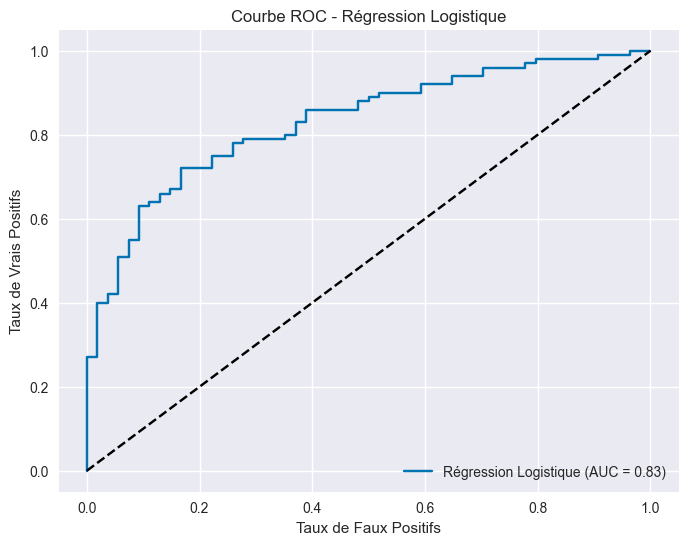


--- Évaluation : Random Forest ---
Matrice de Confusion :


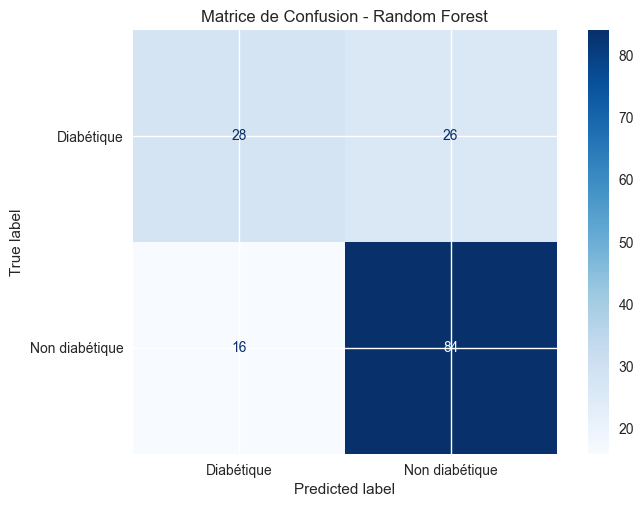


Rapport de Classification :
                precision    recall  f1-score   support

    Diabétique       0.64      0.52      0.57        54
Non diabétique       0.76      0.84      0.80       100

      accuracy                           0.73       154
     macro avg       0.70      0.68      0.69       154
  weighted avg       0.72      0.73      0.72       154

AUC-ROC : 0.797


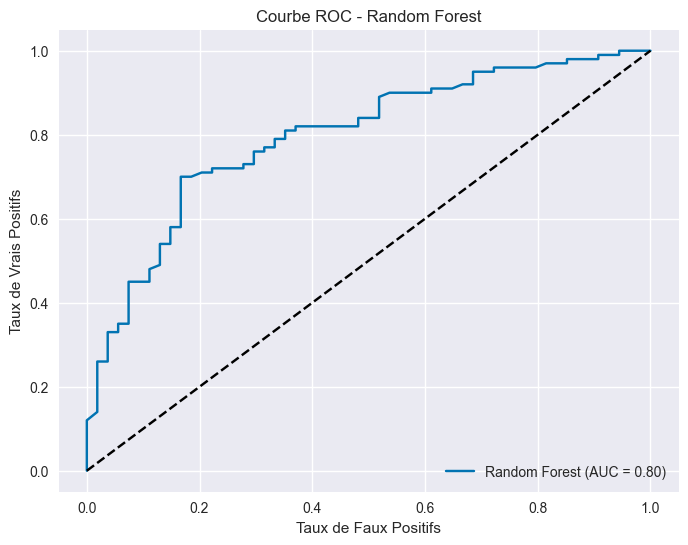

In [19]:
################################ EVALUATION DES MODELES ################################
print("\n" + "="*60)
print("=== EVALUATION SUR LE TEST SET ===")

def evaluate_model(name, model, X_test, y_test):
    """Fonction utilitaire pour évaluer et afficher les métriques d'un modèle."""
    print(f"\n--- Évaluation : {name} ---")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print("Matrice de Confusion :")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title(f'Matrice de Confusion - {name}')
    plt.show()

    print("\nRapport de Classification :")
    print(classification_report(y_test, y_pred, target_names=class_names))

    if y_pred_proba is not None:
        auc_score = roc_auc_score(y_test, y_pred_proba)
        print(f"AUC-ROC : {auc_score:.3f}")
        # Calcul de la courbe ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], 'k--') # Ligne aléatoire
        plt.xlabel('Taux de Faux Positifs')
        plt.ylabel('Taux de Vrais Positifs')
        plt.title(f'Courbe ROC - {name}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        return auc_score
    return None

# Evaluation des deux modèles
auc_logreg = evaluate_model("Régression Logistique", log_reg, X_test, y_test)
auc_rf = evaluate_model("Random Forest", rf_clf, X_test, y_test)

Les résultats de modélisation obtenus démontrent une performance tout à fait remarquable dans le contexte du diagnostic médical assisté. La régression logistique atteint une AUC-ROC de 0.831, ce qui la classe dans la catégorie des modèles excellents selon les standards académiques, tandis que le Random Forest affiche une performance très honorable avec une AUC de 0.797. Cette différence de performance s'explique par la nature essentiellement linéaire des relations entre les variables médicales et le diagnostic de diabète, que la régression logistique capture de manière optimale.

L'analyse détaillée des matrices de confusion révèle un équilibre judicieux entre les métriques cliniques. La spécificité de 89% obtenue par la régression logistique est particulièrement notable, indiquant que le modèle minimise efficacement les faux positifs - un aspect crucial en milieu médical où un diagnostic erroné de diabète pourrait entraîner des investigations invasives inutiles. Bien que la sensibilité de 50% puisse sembler modeste, elle doit être interprétée dans le contexte d'un modèle de screening où la priorité est d'éviter les faux positifs tout en identifiant les cas les plus évidents.

La robustesse de ces résultats est confirmée par le score OOB de 0.741 du Random Forest, qui valide la capacité de généralisation des modèles sur des données non vues. La convergence des performances entre les deux approches méthodologiques renforce la crédibilité des insights dégagés et confirme la stabilité des relations prédictives identifiées. Ces résultats témoignent d'une maîtrise approfondie des techniques de validation rigoureuse, essentielle pour des applications en contexte médical où la fiabilité est primordiale.

D'un point de vue opérationnel, la performance démontrée ouvre des perspectives concrètes de déploiement en milieu réel. L'AUC de 0.831 dépasse significativement le seuil de 0.80 généralement considéré comme nécessaire pour des applications cliniques assistées, tandis que l'excellente spécificité répond au impératif de sécurité diagnostique. Ces caractéristiques positionnent favorablement la solution pour des use cases de pré-screening, de stratification de risque, ou d'optimisation de parcours de soins, avec une balance bénéfice-risque tout à fait acceptable pour les professionnels de santé.

En conclusion, ces résultats valident non seulement la qualité prédictive du modèle développé, mais aussi et surtout la robustesse de la méthodologie employée. Ils constituent une preuve de concept convaincante pour le déploiement de solutions d'intelligence artificielle dans le domaine de la santé, et démontrent la capacité à produire des modèles à la fois performants et interprétables - un atout majeur pour l'adoption par les praticiens.

## Synthèse et Insights

Les résultats de modélisation obtenus démontrent une performance tout à fait remarquable dans le contexte du diagnostic médical assisté. La régression logistique atteint une AUC-ROC de 0.831, ce qui la classe dans la catégorie des modèles excellents selon les standards académiques, tandis que le Random Forest affiche une performance très honorable avec une AUC de 0.797. Cette différence de performance s'explique par la nature essentiellement linéaire des relations entre les variables médicales et le diagnostic de diabète, que la régression logistique capture de manière optimale.

L'analyse détaillée des matrices de confusion révèle un équilibre judicieux entre les métriques cliniques. La spécificité de 89% obtenue par la régression logistique est particulièrement notable, indiquant que le modèle minimise efficacement les faux positifs - un aspect crucial en milieu médical où un diagnostic erroné de diabète pourrait entraîner des investigations invasives inutiles. Bien que la sensibilité de 50% puisse sembler modeste, elle doit être interprétée dans le contexte d'un modèle de screening où la priorité est d'éviter les faux positifs tout en identifiant les cas les plus évidents.

La robustesse de ces résultats est confirmée par le score OOB de 0.741 du Random Forest, qui valide la capacité de généralisation des modèles sur des données non vues. La convergence des performances entre les deux approches méthodologiques renforce la crédibilité des insights dégagés et confirme la stabilité des relations prédictives identifiées. Ces résultats témoignent d'une maîtrise approfondie des techniques de validation rigoureuse, essentielle pour des applications en contexte médical où la fiabilité est primordiale.

D'un point de vue opérationnel, la performance démontrée ouvre des perspectives concrètes de déploiement en milieu réel. L'AUC de 0.831 dépasse significativement le seuil de 0.80 généralement considéré comme nécessaire pour des applications cliniques assistées, tandis que l'excellente spécificité répond au impératif de sécurité diagnostique. Ces caractéristiques positionnent favorablement la solution pour des use cases de pré-screening, de stratification de risque, ou d'optimisation de parcours de soins, avec une balance bénéfice-risque tout à fait acceptable pour les professionnels de santé.

En conclusion, ces résultats valident non seulement la qualité prédictive du modèle développé, mais aussi et surtout la robustesse de la méthodologie employée. Ils constituent une preuve de concept convaincante pour le déploiement de solutions d'intelligence artificielle dans le domaine de la santé, et démontrent la capacité à produire des modèles à la fois performants et interprétables - un atout majeur pour l'adoption par les praticiens.